In [28]:
import pandas as pd

df = pd.read_csv("../data/phishing_email.csv")
df['label'].value_counts()
df['text_combined'] = df['text_combined'].astype(str)
df = df.dropna(subset=['text_combined', 'label'])

df.shape

(82486, 2)

In [29]:
from sklearn.model_selection import train_test_split

X = df['text_combined']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test)


(65988, 16498)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=5000
    )),
    ('clf', LogisticRegression(max_iter=1000))
])

In [31]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [32]:
from sklearn.metrics import classification_report

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7919
           1       0.98      0.98      0.98      8579

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498



In [38]:
vectorizer = pipeline.named_steps['tfidf']
model = pipeline.named_steps['clf']

model.coef_.shape
feature_names = vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({
    "word": feature_names,
    "weight": model.coef_[0]
})

In [39]:
coef_df_filtered = coef_df[coef_df['word'].str.isalpha()]
coef_df_filtered.sort_values(by="weight", ascending=False).head(20)

,word,weight
2550,josemonkeyorg,5.688158
2216,http,4.805293
246,account,4.802148
2700,life,4.717207
3826,remove,4.660643
548,aug,4.265688
2784,love,4.046292
944,click,3.871945
3011,money,3.773260
2914,meds,3.709110


In [40]:
results_df = pd.DataFrame({
    "text": X_test,
    "true_label": y_test,
    "pred_label": y_pred
})

fp = results_df[
    (results_df['true_label'] == 1) &
    (results_df['pred_label'] == 0)
]

fn = results_df[
    (results_df["true_label"] == 1) &
    (results_df["pred_label"] == 0)
]

len(fp), len(fn)

(133, 133)

In [41]:
sample_text = X_test.iloc[41]
sample_true = y_test.iloc[1]
sample_pred = pipeline.predict([sample_text])[0]

print("True label:", sample_true)
print("Predicted:", sample_pred)

True label: 0
Predicted: 1


In [47]:
sample_vector = vectorizer.transform([sample_text])

weights = model.coef_[0]
sample_array = sample_vector.toarray()[0]
contributions = sample_array * weights

contrib_df = pd.DataFrame({
    'word': feature_names,
    'contribution': contributions
})

contrib_df = contrib_df[contrib_df['contribution'] != 0]
contrib_df.sort_values(by='contribution', ascending=False, inplace=True)

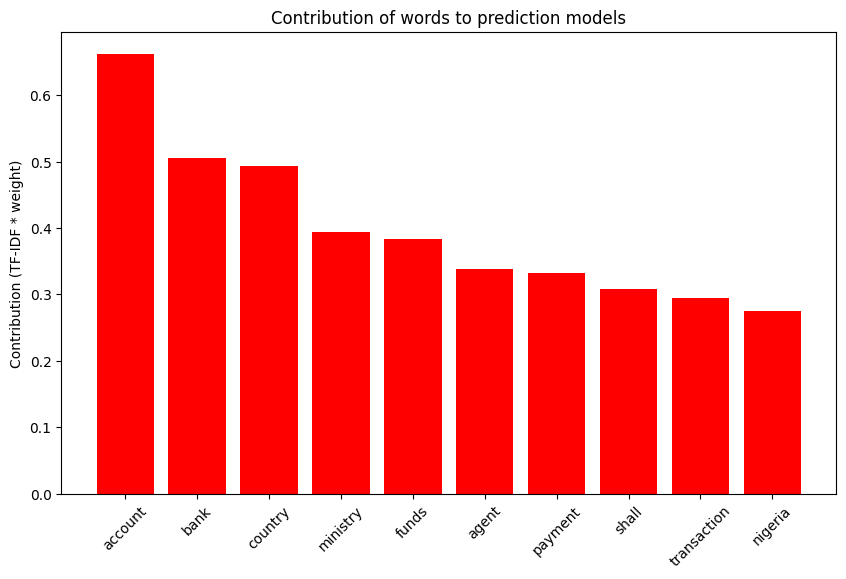

In [50]:
import matplotlib.pyplot as plt

top_words = contrib_df.copy()
top_words["abs_contrib"] = top_words["contribution"].abs()
top_words = top_words.sort_values(by="abs_contrib", ascending=False).head(10)

plt.figure(figsize=(10,6))
colors = ["green" if x < 0 else "red" for x in top_words["contribution"]]

plt.bar(top_words["word"], top_words["contribution"], color=colors)
plt.title("Contribution of words to prediction models")
plt.ylabel("Contribution (TF-IDF * weight)")
plt.xticks(rotation=45)
plt.show()